# Importing packages and reading images using image generator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import keras 
import random
from  keras.applications.efficientnet import EfficientNetB1,preprocess_input,decode_predictions
import warnings 
warnings.simplefilter(action="ignore")

2024-07-25 15:53:27.936188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 15:53:27.936325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 15:53:28.063557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path = r"/kaggle/input/intel-image-classification/seg_train/seg_train"
test_path = r"/kaggle/input/intel-image-classification/seg_test/seg_test"
pred_path = r"/kaggle/input/intel-image-classification/seg_pred/seg_pred"
img_size = (150,150)
mode="rgb"
batch_s = 128

In [3]:
for file in os.listdir(train_path):
    print(file)

mountain
street
buildings
sea
forest
glacier


In [4]:
train_val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	fill_mode="nearest")
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_data = train_val_generator.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode=mode,
    batch_size=batch_s,
    class_mode="categorical",
    shuffle=True,
    seed=7,
    subset="training"
)

val_data = train_val_generator.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode=mode,
    batch_size=batch_s,
    class_mode="categorical",
    shuffle=True,
    seed=7,
    subset="validation"
)

test_data = test_generator.flow_from_directory(
    test_path,
    target_size=img_size,
    color_mode=mode,
    batch_size=batch_s,
    class_mode="categorical",
    shuffle=False,
    seed=7,
)

Found 10528 images belonging to 6 classes.
Found 3506 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Taking a look at the images

In [6]:
train_counts = {expression: len(os.listdir(os.path.join(train_path, expression))) 
                for expression in os.listdir(train_path)}
train_count_df = pd.DataFrame(train_counts, index=['train'])

In [7]:
test_counts = {expression: len(os.listdir(os.path.join(test_path, expression))) 
               for expression in os.listdir(test_path)}
test_count_df = pd.DataFrame(test_counts, index=['test'])

In [8]:
train_count_df

mountain  street  buildings   sea  forest  glacier
train      2512    2382       2191  2274    2271     2404

In [9]:
test_count_df

mountain  street  buildings  sea  forest  glacier
test       525     501        437  510     474      553

<Axes: >

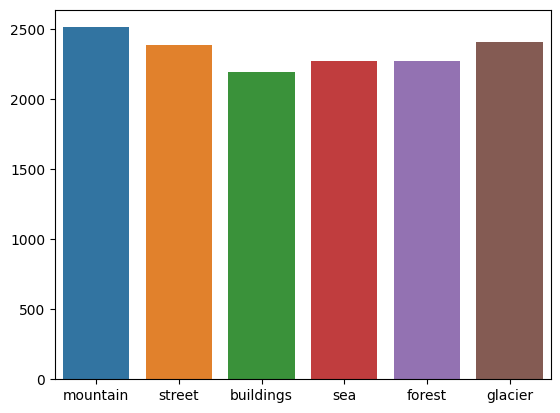

In [10]:
sns.barplot(data=train_count_df)

<Axes: >

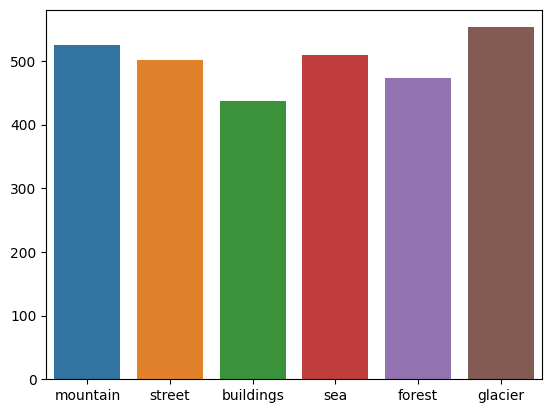

In [11]:
sns.barplot(data=test_count_df)

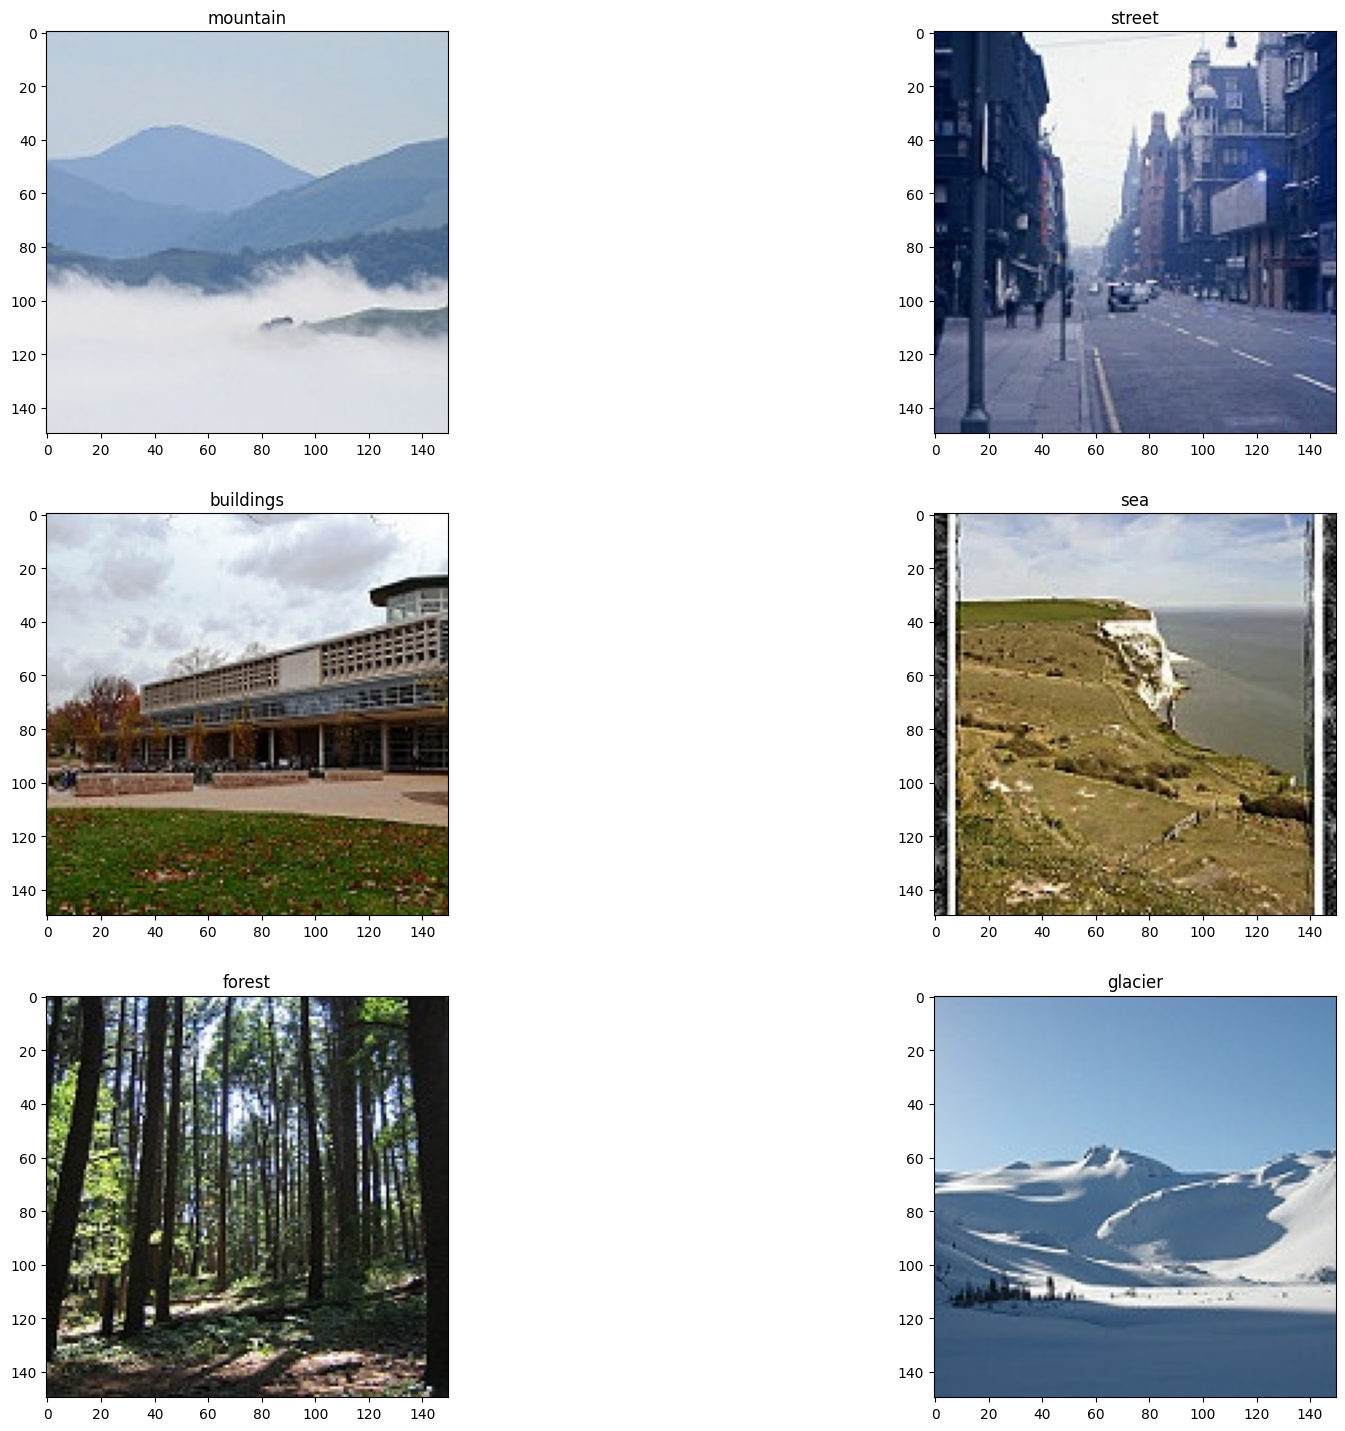

In [12]:
class_dirs = os.listdir(train_path)
plt.figure(figsize=(21, 24))
for i in range(len(class_dirs)):
    plt.subplot(4,2,i+1)
    img_path = f"{train_path}/{class_dirs[i]}/{os.listdir(f'{train_path}/{class_dirs[i]}')[0]}"
    img = plt.imread(img_path)
    plt.title(class_dirs[i])
    plt.imshow(img,cmap="brg")

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adamax

input_tensor = Input(shape=(150, 150, 3))

base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling='max')
x = base_model.output
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adamax(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Training and Evaluating the model

In [19]:
history = model.fit(train_data,validation_data=val_data, epochs=25)

Epoch 1/25


W0000 00:00:1721923574.661222     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/83 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3224 - loss: 1.8581   

W0000 00:00:1721923672.954710     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3352 - loss: 1.8206

W0000 00:00:1721923681.716587     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.3369 - loss: 1.8155 - val_accuracy: 0.1620 - val_loss: 2.8400
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7615 - loss: 0.6749 - val_accuracy: 0.1620 - val_loss: 2.5204
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8498 - loss: 0.4488 - val_accuracy: 0.2034 - val_loss: 2.0942
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8810 - loss: 0.3657 - val_accuracy: 0.1771 - val_loss: 2.1345
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9021 - loss: 0.2950 - val_accuracy: 0.2456 - val_loss: 1.8179
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9085 - loss: 0.2735 - val_accuracy: 0.3668 - val_loss: 1.5026
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9189 - loss: 0.2443 - val_accuracy: 0.6021 - val_loss: 1.0297
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9272 - loss: 0.2123 - val_accuracy: 0.7524 - val_loss: 0.7026


In [20]:
model.evaluate(test_data)

24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9246 - loss: 0.3959


[0.367443323135376, 0.9266666769981384]

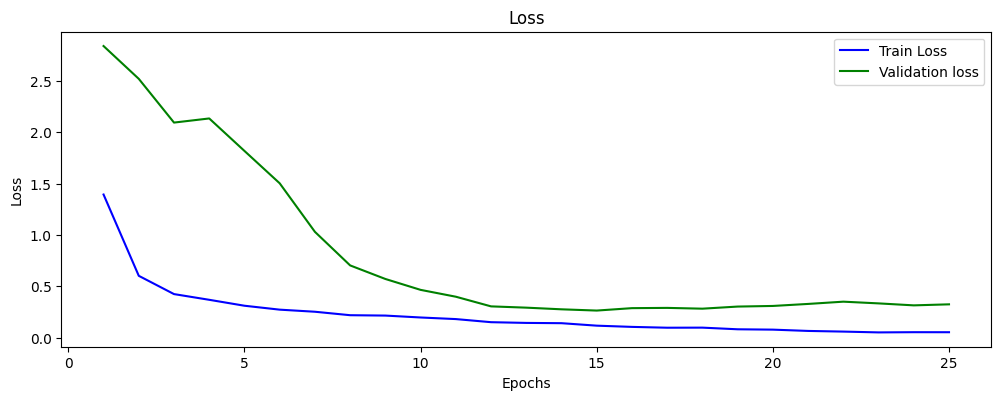

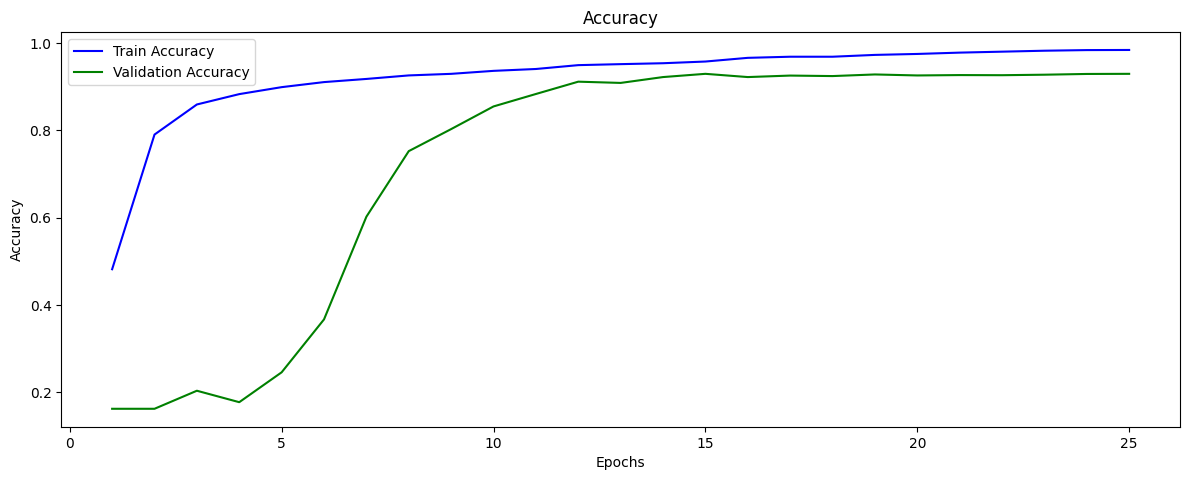

In [21]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_loss,'b',label="Train Loss")
plt.plot(epochs,val_loss,'g',label="Validation loss")
plt.title("Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_acc,'b',label="Train Accuracy")
plt.plot(epochs,val_acc,'g',label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [22]:
test_data.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

# predicting random images from the predict directory

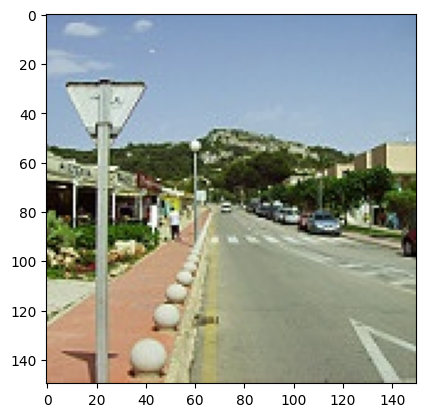

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
street


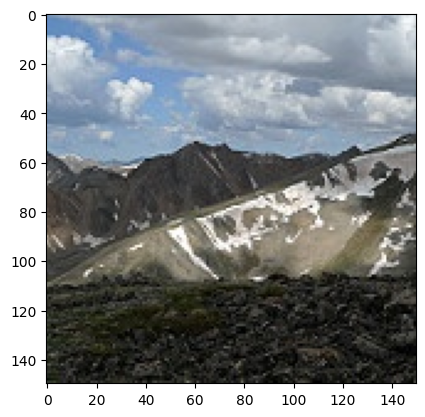

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Glacier


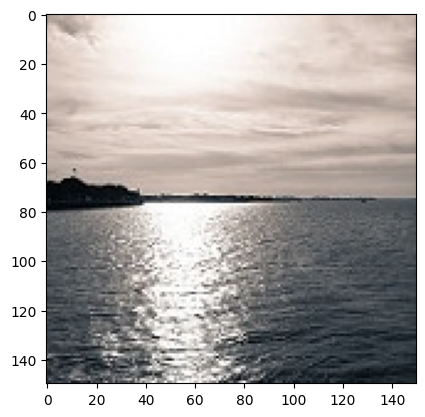

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sea


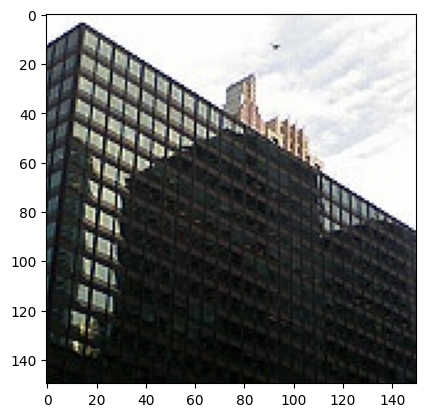

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Building


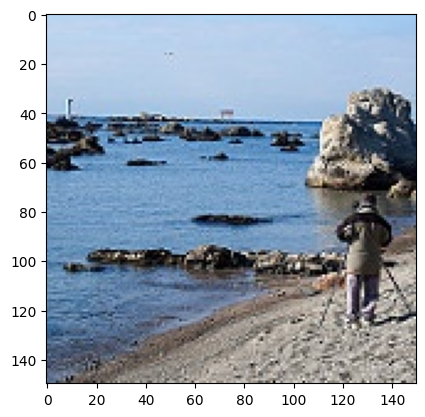

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sea


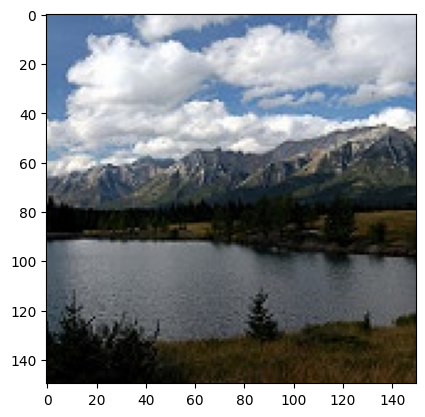

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Glacier


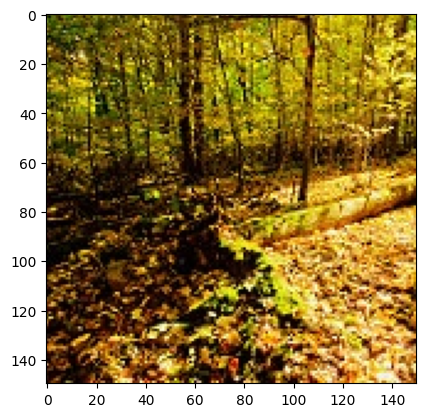

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Forest


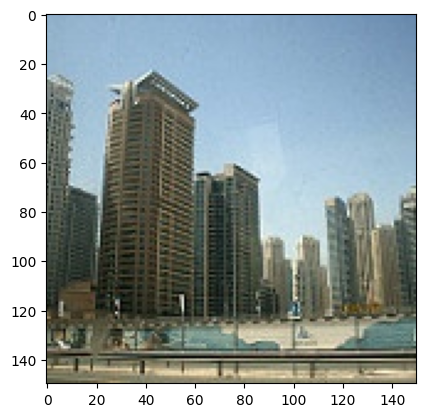

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Building


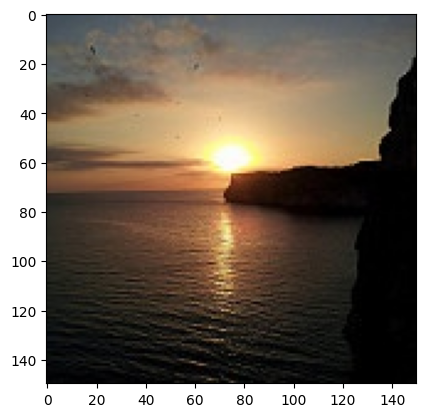

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sea


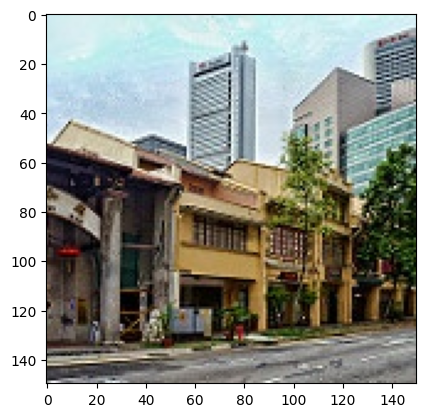

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
street


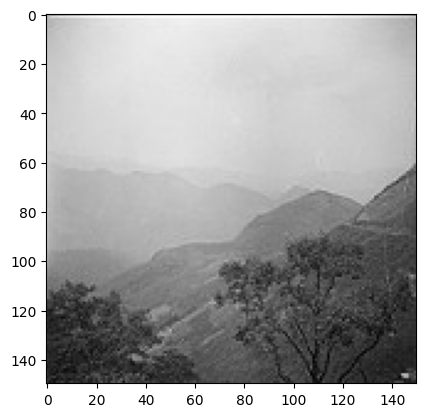

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mountain


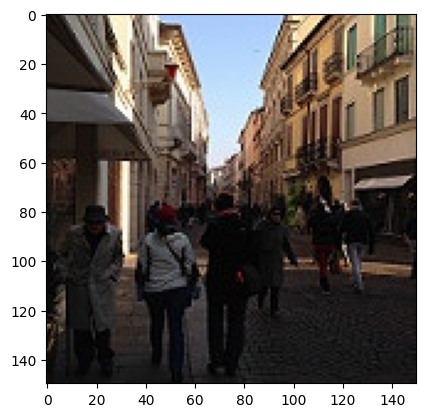

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
street


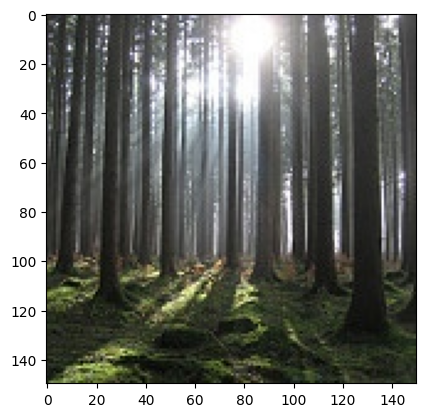

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Forest


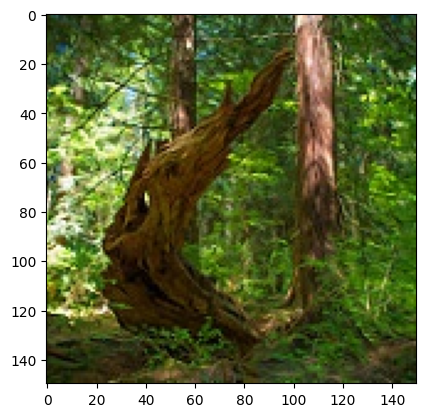

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Forest


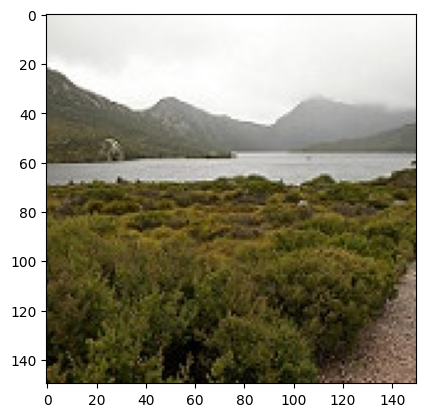

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sea


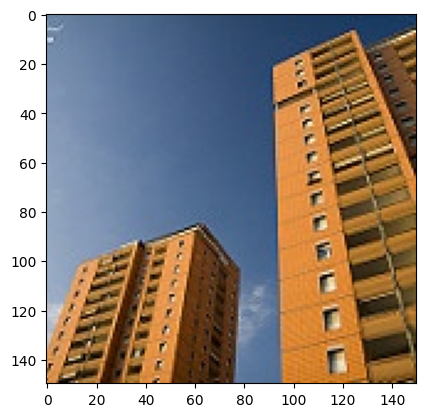

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Building


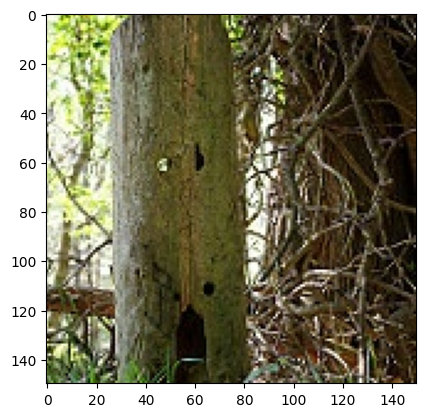

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Forest


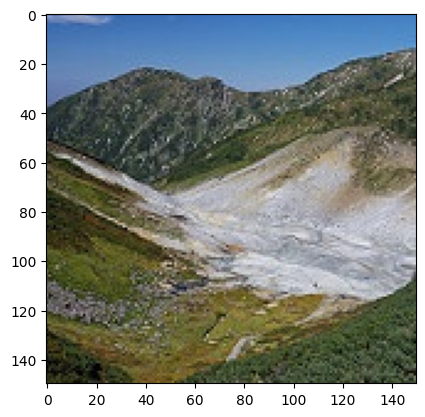

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Glacier


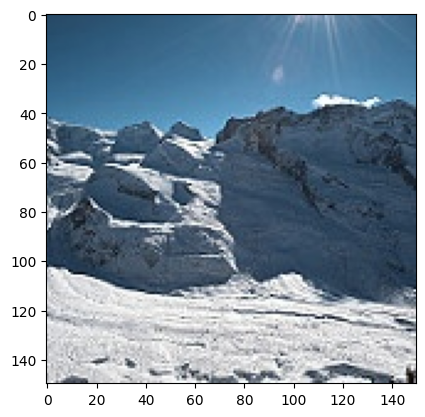

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mountain


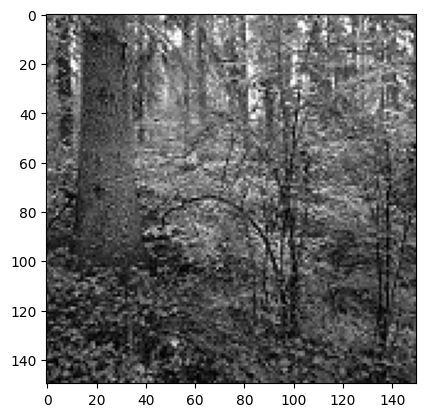

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Forest


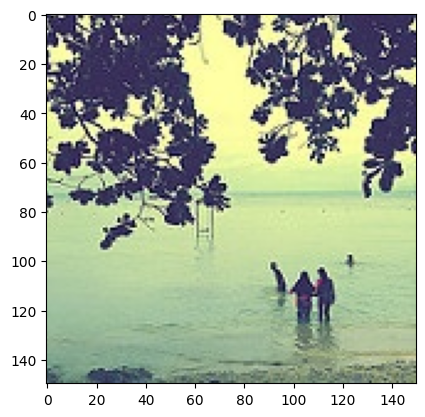

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sea


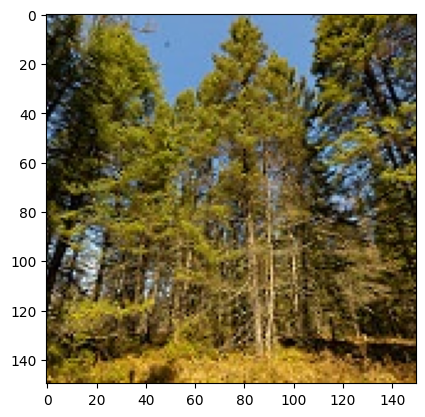

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Forest


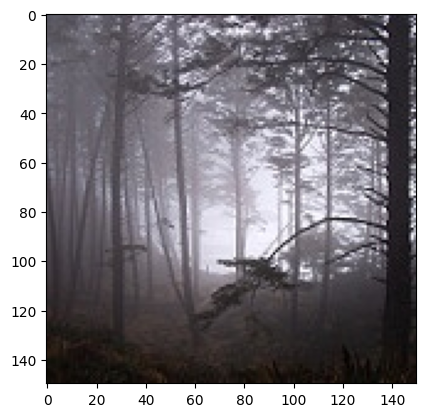

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Forest


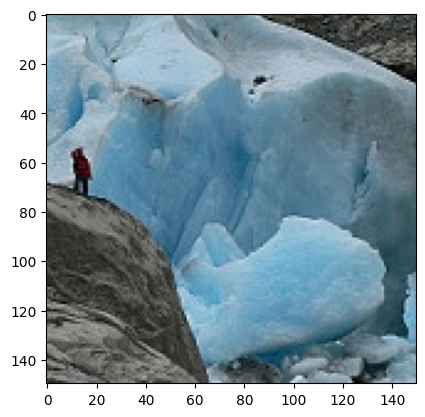

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Glacier


In [23]:
pred_list = os.listdir("/kaggle/input/intel-image-classification/seg_pred/seg_pred")

for i in range(random.randint(30,40), random.randint(50,60)):
    path = os.path.join(pred_path, pred_list[i])
    img = cv2.imread(path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()
    img = np.expand_dims(img/255, 0)
    pred = np.argmax(model.predict(img))
    if pred == 0:
        print('Building')
    elif pred == 1:
        print('Forest')
    elif pred == 2:
        print('Glacier')
    elif pred == 3:
        print('Mountain')
    elif pred == 4:
        print('Sea')
    elif pred == 5:
        print('street')

# Classification report and confusion matrix

In [24]:
predictions = model.predict(test_data) 
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes

 2/24 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

W0000 00:00:1721926582.187101     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step


In [25]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       437
           1       0.99      0.99      0.99       474
           2       0.89      0.88      0.89       553
           3       0.90      0.86      0.88       525
           4       0.95      0.96      0.96       510
           5       0.92      0.95      0.93       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



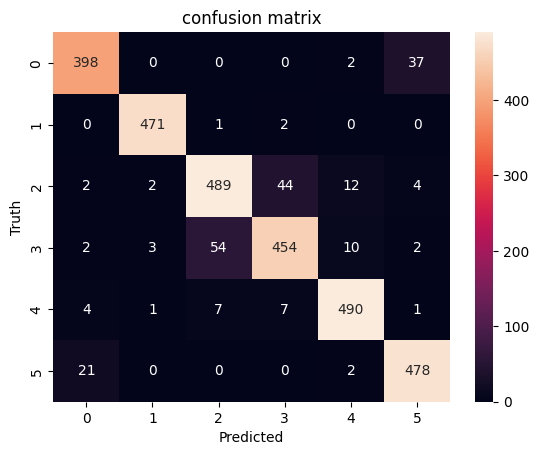

In [27]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("confusion matrix")
plt.show()